<a href="https://colab.research.google.com/github/duonghung86/Injury-severity-classification/blob/main/VCA_2_1_MLP_earlystopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
# Basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import os
# Preprocessing
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Machine learning algos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Metrics
from imblearn.metrics import geometric_mean_score
# Tensorflow
import tensorflow as tf
print(tf.__version__)
from tensorflow import feature_column  # for data wrangling
from tensorboard.plugins.hparams import api as hp

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

2.3.0


In [ ]:
# Download dataset
url = 'https://github.com/duonghung86/Injury-severity-classification/blob/main/Prepared%20Texas%202019.zip?raw=true' 
tf.keras.utils.get_file(origin=url, fname=url.split('/')[-1], extract=True)
data_path = '/root/.keras/datasets/' + url.split('/')[-1].split('?')[0].replace('%20',' ').replace('.zip','.csv')

10592256/10587626 [==============================] - 0s 0us/step


In [ ]:
# Load data
df = pd.read_csv(data_path)
print(df.shape)
df.head(3)

(949856, 19)


,Prsn_Injry_Sev,Prsn_Age,Prsn_Gndr,Wthr_Cond,Light_Cond,Surf_Cond,Veh_Body_Styl,Prsn_Rest,Prsn_Drg_Rslt,Harm_Evnt,Rural,Crash_Speed_Limit,Road_Algn,Veh_Mod_Year,Weekend,Crash_season,Part_of_day,Collsn_type,Collsn_name
0,0,26,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",33,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
1,0,52,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",19,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
2,0,27,FEMALE,CLEAR,DAYLIGHT,DRY,PICKUP,SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,1,-1,"CURVE, LEVEL",16,1,3,4,SAME DIRECTION,BOTH LEFT TURN


In [ ]:
# Let's just use 80% of the total dataset
#df, _ = train_test_split(df, test_size=0.2,stratify = df['Prsn_Injry_Sev'])
#df.shape

In [ ]:
y = df['Prsn_Injry_Sev']
print('All target values:')
print(y.value_counts())
X = df.drop(columns=['Prsn_Injry_Sev'])

All target values:
0    792558
1    102409
2     45242
3      7951
4      1696
Name: Prsn_Injry_Sev, dtype: int64


In [ ]:
# %% Data wrangling -------------
# Classify variable type
emb_vars, ind_vars, num_vars = [], [], []
for var in X.columns:
    if X[var].dtypes == 'O':
        if len(X[var].unique()) > 5:
            emb_vars.append(var)
        else:
            ind_vars.append(var)
    else:
        num_vars.append(var)
print('Numerical variables are ', num_vars)
print('Categorical variables that have at most 5 categories are ', ind_vars)
print('Categorical variables that have more than 5 categories are ', emb_vars)

# Create feature columns
feature_columns = []
# numeric cols
for header in num_vars:
    feature_columns.append(feature_column.numeric_column(header))
# bucketized cols
# age = feature_column.numeric_column('Prsn_Age')
# age_buckets = feature_column.bucketized_column(age, boundaries=[16, 22, 35, 55, 65])
# feature_columns.append(age_buckets)
# indicator_columns
for col_name in ind_vars:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
        col_name, X[col_name].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)
# embedding columns
for col_name in emb_vars:
    emb_column = feature_column.categorical_column_with_vocabulary_list(
        col_name, X[col_name].unique())
    col_embedding = feature_column.embedding_column(emb_column, dimension=5)
    feature_columns.append(col_embedding)

# Convert all setup into new dataset
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
X = feature_layer(dict(X)).numpy()
print('New shape of the input data set:',X.shape)

Numerical variables are  ['Prsn_Age', 'Rural', 'Crash_Speed_Limit', 'Veh_Mod_Year', 'Weekend', 'Crash_season', 'Part_of_day']
Categorical variables that have at most 5 categories are  ['Prsn_Gndr', 'Prsn_Drg_Rslt', 'Collsn_type']
Categorical variables that have more than 5 categories are  ['Wthr_Cond', 'Light_Cond', 'Surf_Cond', 'Veh_Body_Styl', 'Prsn_Rest', 'Harm_Evnt', 'Road_Algn', 'Collsn_name']
New shape of the input data set: (949856, 59)


In [ ]:
# %% Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=48)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=48)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

# %% standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Training features shape: (607907, 59)
Validation features shape: (151977, 59)
Test features shape: (189972, 59)


# ALL mini functions



In [ ]:
# %% Function to compare the prediction and true labels
def get_accs(label, prediction, show=True):
    cm = confusion_matrix(label, prediction)
    length = cm.shape[0]
    num_cases = len(label)
    # global accuracy
    glb_acc = np.trace(cm) / len(label)
    ind_accs = cm / np.sum(cm, axis=1)[:, np.newaxis]
    accs = [ind_accs[i, i] for i in range(length)]
    index = ['Class {}'.format(i) for i in range(length)]
    # Global accuracy
    accs.append(glb_acc)
    index.append('Overall Accuracy')
    # G-mean
    accs.append(geometric_mean_score(label, prediction, correction=0.001))
    index.append('G-mean')
    # Average perf
    accs.append((glb_acc + accs[-1]) / 2)
    index.append('Avg_Pfm')
    if show:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.heatmap(cm, xticklabels=np.arange(length), yticklabels=np.arange(length),
                    annot=True, fmt='g', cmap="YlGnBu")
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.title('Confusion matrix')
        plt.subplot(1, 2, 2)
        sns.heatmap(ind_accs * 100, xticklabels=np.arange(length), yticklabels=np.arange(length),
                    annot=True, fmt='.2f', cmap="YlGnBu")
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.title('Normalized confusion matrix (%)')
        plt.show()
    out = np.array(accs).reshape(1, len(accs))
    return pd.DataFrame(out, columns=index)

def show_evolution(moni):
    hist = pd.DataFrame(monitor.history)
    no_metrics = np.int(hist.shape[1]/2)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2), dpi=150)
    for i in range(2):
      hist.iloc[:,[i,no_metrics+i]].plot(ax=axes[i])
    plt.show()
# %% Produce an evaluation on the MLP model
def evaluation(model, monitor, time, name):
    # use the model to make predictions with the test data
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    # Show evolution of the training process
    show_evolution(monitor)
    # get the evaluation metrics
    result = get_accs(y_test.values, y_pred, False)
    result['Training Time'] = np.round(time, 3)
    result.index = [name]
    return result

LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


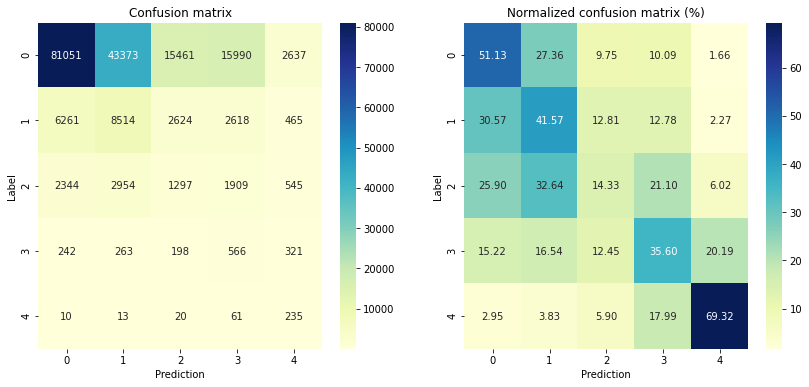

DT


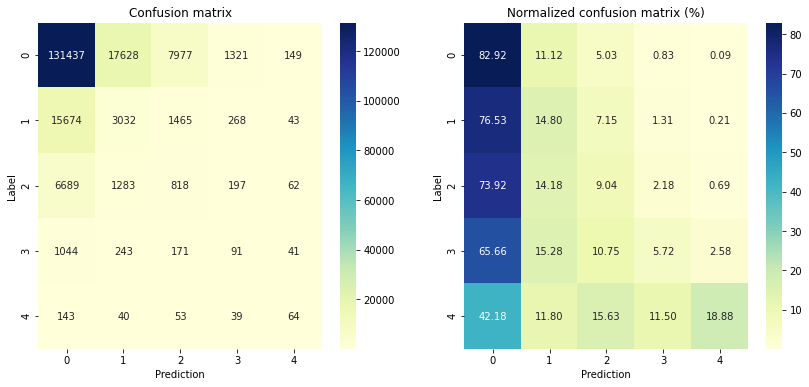

RF


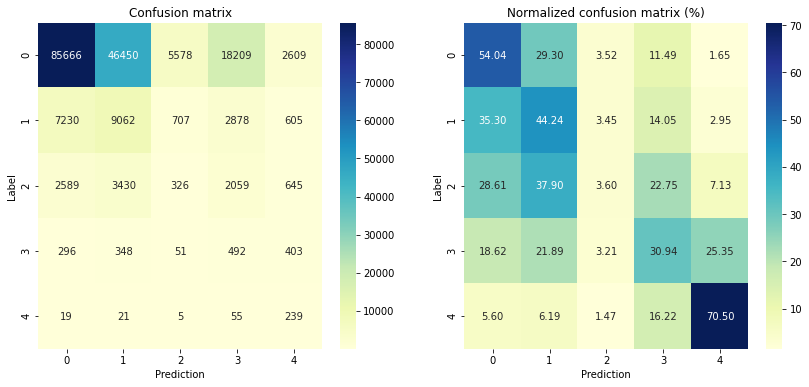

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
LR,0.511324,0.415682,0.143331,0.355975,0.693215,0.482508,0.376025,0.429267,48.178
DT,0.829193,0.148032,0.090397,0.057233,0.188791,0.712958,0.164346,0.438652,21.347
RF,0.540439,0.442437,0.036026,0.309434,0.705015,0.504206,0.284968,0.394587,56.692


In [ ]:
wgt='balanced'
clfs = [LogisticRegression(solver = 'lbfgs',class_weight=wgt),
        DecisionTreeClassifier(class_weight=wgt),
        RandomForestClassifier(max_depth=4,class_weight=wgt)]
clf_names = ['LR','DT','RF']
rsts = pd.DataFrame()
for model, name in zip(clfs,clf_names):
    start = time.time()
    print(name)
    model.fit(X_train, y_train.values)
    # use the model to make predictions with the test data
    y_pred = model.predict(X_test)
    end= time.time()
    # get the evaluation metrics
    result = get_accs(y_test.values,y_pred,True)
    result['Training Time'] = np.round(end-start,3)
    result.index = [name]
    rsts = rsts.append(result)
rsts

# MLP functions


In [ ]:
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_addons.metrics import CohenKappa,F1Score

In [ ]:
# Add weights
weights = len(y) / (5 * np.bincount(y))
cls_wgt = dict(zip(np.arange(5), weights))
cls_wgt

{0: 0.23969375111979185,
 1: 1.855024460740755,
 2: 4.199000928340922,
 3: 23.89274305118853,
 4: 112.01132075471698}

In [ ]:
def early_stops(metric_name):
    es = EarlyStopping(monitor='val_'+ metric_name,
                   verbose=1,
                   patience=10,
                   mode='max',
                   restore_best_weights=True)
    return es

# Ordinal multiclass


In [ ]:
early_stop = {'accuracy':  tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
              'cohen_kappa': CohenKappa(num_classes=5,sparse_labels=True),
              'f1_score': F1Score(num_classes=5,average="micro",threshold=0.5),
               }

In [ ]:
def create_mlp(metric):
    MLP = Sequential([Dense(10,
                           activation='relu',
                           input_dim=X_train.shape[1]
                           ),
                      Dropout(0.5),
                      Dense(5, activation='softmax')])
    MLP.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[metric]
               )
    return MLP

Epoch 1/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.5180 - accuracy: 0.4116 - val_loss: 1.4197 - val_accuracy: 0.4730
Epoch 2/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4907 - accuracy: 0.4154 - val_loss: 1.4278 - val_accuracy: 0.4554
Epoch 3/50
18998/18998 [==============================] - 24s 1ms/step - loss: 1.4911 - accuracy: 0.4053 - val_loss: 1.4229 - val_accuracy: 0.4544
Epoch 4/50
18998/18998 [==============================] - 24s 1ms/step - loss: 1.4817 - accuracy: 0.4055 - val_loss: 1.4342 - val_accuracy: 0.4368
Epoch 5/50
18998/18998 [==============================] - 24s 1ms/step - loss: 1.4818 - accuracy: 0.4136 - val_loss: 1.4150 - val_accuracy: 0.4572
Epoch 6/50
18998/18998 [==============================] - 24s 1ms/step - loss: 1.4802 - accuracy: 0.4067 - val_loss: 1.4397 - val_accuracy: 0.4177
Epoch 7/50
18998/18998 [==============================] - 24s 1ms/step - loss: 1.4782 - accuracy: 0.4059 - val_loss: 1

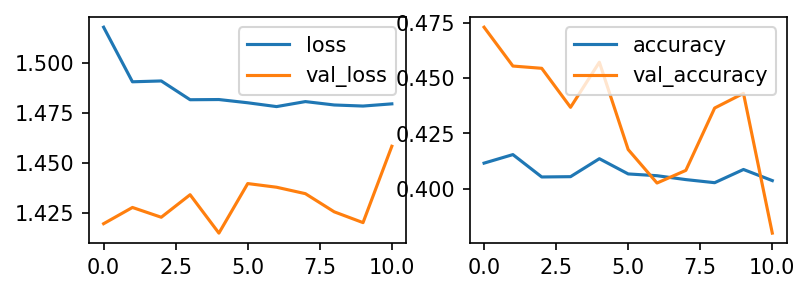

Epoch 1/50
18998/18998 [==============================] - 27s 1ms/step - loss: 1.5349 - cohen_kappa: 0.0376 - val_loss: 1.4349 - val_cohen_kappa: 0.0853
Epoch 2/50
18998/18998 [==============================] - 27s 1ms/step - loss: 1.5082 - cohen_kappa: 0.0529 - val_loss: 1.4400 - val_cohen_kappa: 0.0836
Epoch 3/50
18998/18998 [==============================] - 31s 2ms/step - loss: 1.5000 - cohen_kappa: 0.0570 - val_loss: 1.4641 - val_cohen_kappa: 0.0809
Epoch 4/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4943 - cohen_kappa: 0.0586 - val_loss: 1.4214 - val_cohen_kappa: 0.0875
Epoch 5/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4933 - cohen_kappa: 0.0604 - val_loss: 1.4881 - val_cohen_kappa: 0.0762
Epoch 6/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4928 - cohen_kappa: 0.0615 - val_loss: 1.4580 - val_cohen_kappa: 0.0779
Epoch 7/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4

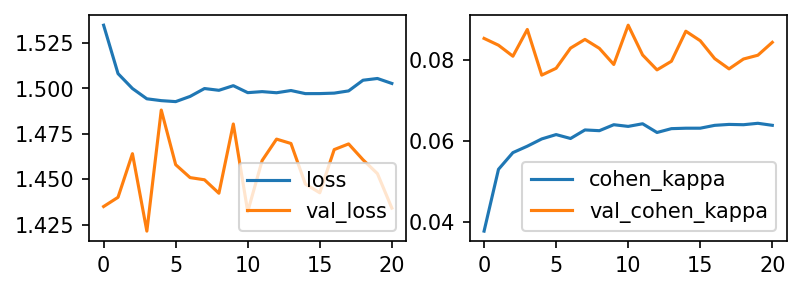

Epoch 1/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.5219 - f1_score: 0.1066 - val_loss: 1.4316 - val_f1_score: 0.1229
Epoch 2/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4863 - f1_score: 0.1135 - val_loss: 1.4333 - val_f1_score: 0.1386
Epoch 3/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4851 - f1_score: 0.1193 - val_loss: 1.4208 - val_f1_score: 0.1362
Epoch 4/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4843 - f1_score: 0.1216 - val_loss: 1.4129 - val_f1_score: 0.1441
Epoch 5/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4791 - f1_score: 0.1241 - val_loss: 1.4274 - val_f1_score: 0.1494
Epoch 6/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4811 - f1_score: 0.1226 - val_loss: 1.4257 - val_f1_score: 0.1327
Epoch 7/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4787 - f1_score: 0.1213 - val_loss: 1

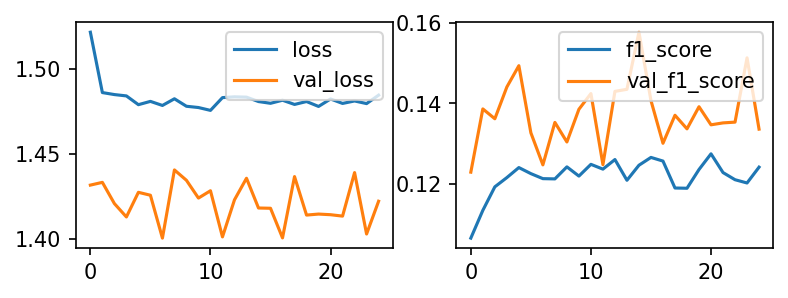

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
LR,0.511324,0.415682,0.143331,0.355975,0.693215,0.482508,0.376025,0.429267,48.178
DT,0.829193,0.148032,0.090397,0.057233,0.188791,0.712958,0.164346,0.438652,21.347
RF,0.540439,0.442437,0.036026,0.309434,0.705015,0.504206,0.284968,0.394587,56.692
MLP accuracy,0.502517,0.404062,0.155818,0.249686,0.731563,0.473680,0.356757,0.415219,268.115
MLP cohen_kappa,0.516289,0.420857,0.212952,0.330818,0.569322,0.490093,0.387303,0.438698,562.290
MLP f1_score,0.443670,0.532956,0.111946,0.350314,0.643068,0.437070,0.359000,0.398035,626.426


In [ ]:
for name, metric in early_stop.items():
    model = create_mlp(metric)
    start = time.time()
    monitor = model.fit(X_train, y_train.values,
                    callbacks=[early_stops(name)],
                    class_weight = cls_wgt,
                    validation_data=(X_val, y_val.values),
                    verbose=1, epochs=50)
    end = time.time()
    rsts = rsts.append(evaluation(model, monitor, end - start,  'MLP '+ name))
rsts

# One-hot encoded multiclass


In [ ]:
 early_stop = {'auc':       tf.keras.metrics.AUC(name='auc'),
     'accuracy':  tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
               'precision': tf.keras.metrics.Precision(name='precision'),
               'recall':    tf.keras.metrics.Recall(name='recall'),
               
               }

In [ ]:
def create_mlp(metric):
    MLP = Sequential([Dense(10,
                           activation='relu',
                           input_dim=X_train.shape[1]
                           ),
                      Dropout(0.5),
                      Dense(5, activation='softmax')])
    MLP.compile(optimizer='adam',
                #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[metric]
               )
    return MLP

In [ ]:
rsts = rsts.iloc[:6,:].copy()

Epoch 1/50
18998/18998 [==============================] - 34s 2ms/step - loss: 1.5548 - auc: 0.7349 - val_loss: 1.4256 - val_auc: 0.7797
Epoch 2/50
18998/18998 [==============================] - 33s 2ms/step - loss: 1.5125 - auc: 0.7479 - val_loss: 1.4012 - val_auc: 0.7973
Epoch 3/50
18998/18998 [==============================] - 35s 2ms/step - loss: 1.5014 - auc: 0.7408 - val_loss: 1.4413 - val_auc: 0.7677
Epoch 4/50
18998/18998 [==============================] - 35s 2ms/step - loss: 1.5034 - auc: 0.7438 - val_loss: 1.4146 - val_auc: 0.7878
Epoch 5/50
18998/18998 [==============================] - 33s 2ms/step - loss: 1.5006 - auc: 0.7455 - val_loss: 1.4362 - val_auc: 0.7704
Epoch 6/50
18998/18998 [==============================] - 33s 2ms/step - loss: 1.5014 - auc: 0.7392 - val_loss: 1.4319 - val_auc: 0.7655
Epoch 7/50
18998/18998 [==============================] - 34s 2ms/step - loss: 1.4997 - auc: 0.7359 - val_loss: 1.4376 - val_auc: 0.7626
Epoch 8/50
18998/18998 [=================

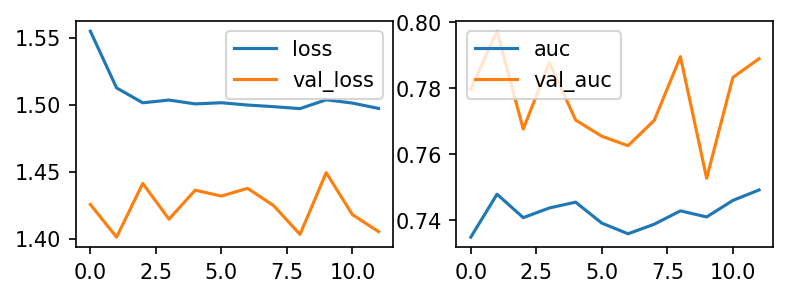

Epoch 1/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.5399 - accuracy: 0.4004 - val_loss: 1.4209 - val_accuracy: 0.4682
Epoch 2/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.5065 - accuracy: 0.4160 - val_loss: 1.4465 - val_accuracy: 0.4295
Epoch 3/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4954 - accuracy: 0.4081 - val_loss: 1.4495 - val_accuracy: 0.4218
Epoch 4/50
18998/18998 [==============================] - 24s 1ms/step - loss: 1.4902 - accuracy: 0.4127 - val_loss: 1.4327 - val_accuracy: 0.4606
Epoch 5/50
18998/18998 [==============================] - 24s 1ms/step - loss: 1.4934 - accuracy: 0.4234 - val_loss: 1.4404 - val_accuracy: 0.4448
Epoch 6/50
18998/18998 [==============================] - 24s 1ms/step - loss: 1.4928 - accuracy: 0.4196 - val_loss: 1.4546 - val_accuracy: 0.4337
Epoch 7/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4936 - accuracy: 0.4227 - val_loss: 1

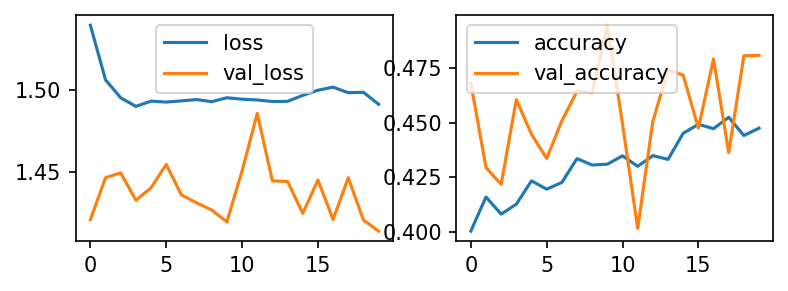

Epoch 1/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.5290 - precision: 0.4647 - val_loss: 1.4384 - val_precision: 0.5299
Epoch 2/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4971 - precision: 0.5014 - val_loss: 1.4335 - val_precision: 0.5643
Epoch 3/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4876 - precision: 0.5108 - val_loss: 1.4550 - val_precision: 0.5072
Epoch 4/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4858 - precision: 0.5154 - val_loss: 1.4351 - val_precision: 0.5547
Epoch 5/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4844 - precision: 0.5132 - val_loss: 1.4497 - val_precision: 0.5168
Epoch 6/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4856 - precision: 0.5064 - val_loss: 1.4354 - val_precision: 0.5614
Epoch 7/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4828 - precision: 0.5165 

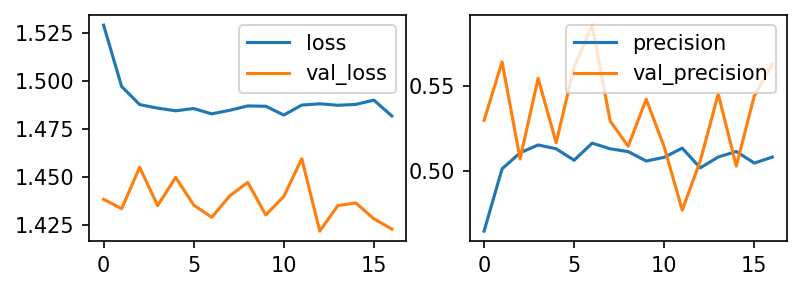

Epoch 1/50
18998/18998 [==============================] - 27s 1ms/step - loss: 1.5205 - recall: 0.2310 - val_loss: 1.4601 - val_recall: 0.3819
Epoch 2/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4932 - recall: 0.4166 - val_loss: 1.4743 - val_recall: 0.3740
Epoch 3/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4868 - recall: 0.4312 - val_loss: 1.4508 - val_recall: 0.4095
Epoch 4/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4807 - recall: 0.4368 - val_loss: 1.4524 - val_recall: 0.4145
Epoch 5/50
18998/18998 [==============================] - 26s 1ms/step - loss: 1.4839 - recall: 0.4410 - val_loss: 1.4548 - val_recall: 0.4127
Epoch 6/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4830 - recall: 0.4477 - val_loss: 1.4431 - val_recall: 0.4219
Epoch 7/50
18998/18998 [==============================] - 25s 1ms/step - loss: 1.4783 - recall: 0.4468 - val_loss: 1.4709 - val_recall: 0.3991

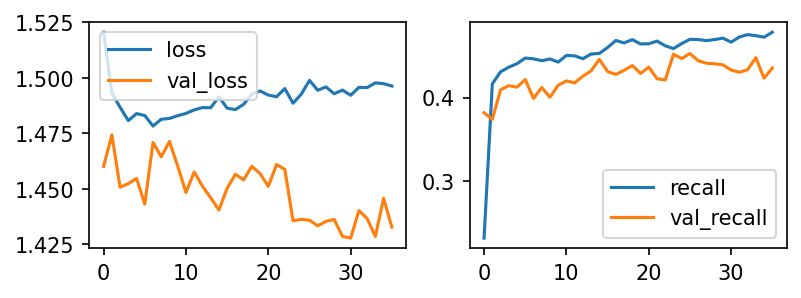

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
LR,0.511324,0.415682,0.143331,0.355975,0.693215,0.482508,0.376025,0.429267,48.178
DT,0.829193,0.148032,0.090397,0.057233,0.188791,0.712958,0.164346,0.438652,21.347
RF,0.540439,0.442437,0.036026,0.309434,0.705015,0.504206,0.284968,0.394587,56.692
MLP accuracy,0.502517,0.404062,0.155818,0.249686,0.731563,0.473680,0.356757,0.415219,268.115
MLP cohen_kappa,0.516289,0.420857,0.212952,0.330818,0.569322,0.490093,0.387303,0.438698,562.290
MLP f1_score,0.443670,0.532956,0.111946,0.350314,0.643068,0.437070,0.359000,0.398035,626.426
MLP 1H auc,0.542066,0.363734,0.176594,0.469811,0.348083,0.504480,0.355700,0.430090,405.786
MLP 1H accuracy,0.537789,0.319793,0.167974,0.418868,0.601770,0.495789,0.373634,0.434711,493.825
MLP 1H precision,0.505665,0.396641,0.160349,0.344654,0.660767,0.476391,0.374069,0.425230,437.159
MLP 1H recall,0.518270,0.450786,0.100785,0.497484,0.401180,0.490725,0.342301,0.416513,930.729


In [ ]:
for name, metric in early_stop.items():
    model = create_mlp(metric)
    start = time.time()
    monitor = model.fit(X_train, pd.get_dummies(y_train).values,
                    callbacks=[early_stops(name)],
                    class_weight = cls_wgt,
                    validation_data=(X_val, pd.get_dummies(y_val).values),
                    verbose=1, epochs=50)
    end = time.time()
    rsts = rsts.append(evaluation(model, monitor, end - start,  'MLP 1H '+ name))
rsts